### Prepare Data

#### Download Dataset

In [ ]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c hubmap-organ-segmentation
! mkdir -p dataset
! unzip -q hubmap-organ-segmentation.zip -d dataset
! rm -rf hubmap-organ-segmentation.zip

100% 5.76G/5.78G [00:25<00:00, 249MB/s]
100% 5.78G/5.78G [00:25<00:00, 239MB/s]


#### Install and Import

In [ ]:
! pip install -q patchify
! pip install -q segmentation-models

     |████████████████████████████████| 58 kB 3.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 1.3 MB/s 


In [ ]:
import json
import os
import pathlib
import warnings
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import patchify
import PIL
import tensorflow as tf
from matplotlib import animation
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tqdm import tqdm

from Manager import InputMode, Manager
from Augment import Augment
from DiceLoss import DiceLoss
from DiceMetric import DiceCoefficient
from UNet import UNet

# import segmentation_models as sm

# from segmentation_models.losses import DiceLoss
# from segmentation_models.metrics import IOUScore

# sm.set_framework('tf.keras')
os.environ['TF_CUDNN_DETERMINISTIC'] = 'false'
os.environ['TF_DETERMINISTIC_OPS'] = 'false'
os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = 'true'


Segmentation Models: using `keras` framework.


#### Create Image Masks

In [ ]:
train_df = pd.read_csv('dataset/train.csv')
# sort train_df by id and reset index
train_df = train_df.sort_values('id')
train_df = train_df.reset_index(drop=True)

In [ ]:
!mkdir -p dataset/train_masks

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1 * 255
    return img.reshape(shape).T

for id in tqdm(train_df['id']):
    rle = train_df[train_df['id'] == id]['rle'].values[0]
    width = train_df[train_df['id'] == id]['img_width'].values[0]
    height = train_df[train_df['id'] == id]['img_height'].values[0]

    mask = rle2mask(rle, (height, width))
    cv2.imwrite(f'dataset/train_masks/{id}.png', mask)

100%|██████████| 351/351 [00:39<00:00,  8.97it/s]


#### Patchify Images and Masks

In [ ]:
def get_correct_dimension(number, divisible):
    if number % divisible == 0:
        return number
    else:
        return number + divisible - (number % divisible)

def correct_image_size(img, size):
    if img.shape[0] != size:
        img = cv2.resize(img, (size, size))
    return img

def display_overlay(image, mask):
    plt.figure(figsize = (7,7))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)

In [ ]:
train_masks_dir = 'dataset/train_masks'
train_masks = [name for name in os.listdir(train_masks_dir)]
train_masks = sorted(train_masks, key=lambda x: int(x.split('.')[0]))

train_images_dir = 'dataset/train_images'
train_images = [name for name in os.listdir(train_images_dir)]
train_images = sorted(train_images, key=lambda x: int(x.split('.')[0]))

assert len(train_masks) == train_df.shape[0]
assert len(train_images) == len(train_masks)

In [ ]:
def subdivide_list(the_list, n_elems):
    return [the_list[i:i+n_elems] for i in range(0,len(the_list), n_elems)]

def subdivide_list_2(the_list, test_size):
    train_list_size = len(the_list) - (2*test_size)
    train_list = [the_list[i:i+train_list_size] for i in range(0, train_list_size, train_list_size)]
    val_list = [the_list[i:i+test_size] for i in range(train_list_size, train_list_size+test_size,train_list_size+test_size )]
    test_list = [the_list[i:i+test_size] for i in range(train_list_size+test_size, train_list_size+test_size+test_size, train_list_size+test_size+test_size)]
    return train_list + val_list + test_list

PATCH_SIZE = 1024
NUMBER_OF_MEMBERS = 117
TEST_SIZE = 65

train_images = subdivide_list_2(train_images, TEST_SIZE)
train_masks = subdivide_list_2(train_masks, TEST_SIZE)

print("Train Images")
for index, value in enumerate(train_images):
    group_path = r'dataset/train_images_' + str(PATCH_SIZE) + '_' + str(index)
    if not os.path.exists(group_path):
        os.makedirs(group_path)

    for train_image_filename in tqdm(value):
        image_id = int(train_image_filename.split('.')[0])
        train_image_file = train_images_dir + '/' + train_image_filename
        image = cv2.imread(train_image_file)
        image = correct_image_size(image, get_correct_dimension(image.shape[0], PATCH_SIZE))

        patched_image = patchify.patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
        for i in range(patched_image.shape[0]):
            for j in range(patched_image.shape[1]):
                cv2.imwrite(group_path + f'/{image_id}_{i}_{j}.png', patched_image[i, j, 0, :, :, :])

print("Train Masks")
for index, value in enumerate(train_masks):
    group_path = r'dataset/train_masks_' + str(PATCH_SIZE) + '_' + str(index)
    if not os.path.exists(group_path):
        os.makedirs(group_path)

    for train_mask_filename in tqdm(value):
        image_id = int(train_mask_filename.split('.')[0])
        train_mask_file = train_masks_dir + '/' + train_mask_filename
        image = cv2.imread(train_mask_file, cv2.IMREAD_GRAYSCALE)
        image = correct_image_size(image, get_correct_dimension(image.shape[0], PATCH_SIZE))

        patched_mask = patchify.patchify(image, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
        for i in range(patched_mask.shape[0]):
            for j in range(patched_mask.shape[1]):
                mask = patched_mask[i, j, :, :]
                mask_location = group_path + f'/{image_id}_{i}_{j}.png'
                cv2.imwrite(mask_location, mask)

                if index < 1 :
                    # Adding augmented duplicate images and masks for non black masks
                    mask = mask / 255.0
                    n_pixels = mask.shape[0] * mask.shape[1]
                    n_white_pixels = mask.sum()
                    white_ratio = n_white_pixels/n_pixels
                    if white_ratio >= 0.05:
                        mask = mask * 255.0
                        corresponding_image_file = 'dataset/train_images_' + str(PATCH_SIZE) + '_' + str(index) + f'/{image_id}_{i}_{j}.png'
                        corresponding_image = cv2.imread(corresponding_image_file)

                        augment = Augment(seed=random.randint(0,1000))

                        mask = np.expand_dims(mask, 2)

                        augmented_image, augmented_mask = augment(corresponding_image, mask)

                        cv2.imwrite(corresponding_image_file.replace('.png', '_copy_1.png'), augmented_image.numpy())
                        cv2.imwrite(mask_location.replace('.png', '_copy_1.png'), augmented_mask.numpy())

                        augment = Augment(seed=random.randint(0,1000))
                        augmented_image, augmented_mask = augment(corresponding_image, mask)

                        cv2.imwrite(corresponding_image_file.replace('.png', '_copy_2.png'), augmented_image.numpy())
                        cv2.imwrite(mask_location.replace('.png', '_copy_2.png'), augmented_mask.numpy())

                        augment = Augment(seed=random.randint(0,1000))
                        augmented_image, augmented_mask = augment(corresponding_image, mask)

                        cv2.imwrite(corresponding_image_file.replace('.png', '_copy_3.png'), augmented_image.numpy())
                        cv2.imwrite(mask_location.replace('.png', '_copy_3.png'), augmented_mask.numpy())

Train Images


100%|██████████| 65/65 [00:46<00:00,  1.40it/s]


Train Masks


100%|██████████| 65/65 [00:05<00:00, 12.52it/s]


### Load and Train Model

#### Load Model

In [ ]:

EPOCHS = 50
WIDTH = 256
HEIGHT = 256
BATCH_SIZE = 16
NUM_CLASSES = 1
VALIDATION_SPLIT = 0.2
SEED = 31415

CSV_ID = 1
MONITOR_MODE = 'loss'
SAVE_BEST = True
EARLY_STOPPING = True
EARLY_STOPPING_PATIENCE = 7

REDUCE_LR = True
REDUCE_LR_FACTOR = 0.2
REDUCE_LR_PATIENCE = 3

THRESHOLD = 0.3


def display_overlay(image, mask):
    plt.figure(figsize = (7,7))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)

In [ ]:
def load_data(image_path, masks_path):
    images_dataset = tf.keras.utils.image_dataset_from_directory(
                image_path,
                seed=SEED,
                #validation_split=0.9,
                #subset="training",
                image_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                labels = None)
    masks_dataset = tf.keras.utils.image_dataset_from_directory(
                masks_path,
                seed=SEED,
                # validation_split=0.9,
                # subset="training",
                image_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                color_mode='grayscale',
                labels = None)
    dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))
    del images_dataset, masks_dataset
    dataset = dataset.map(lambda images, masks: {'image': images, 'segmentation_mask': masks})
    return dataset

In [ ]:
train_images_path = pathlib.Path('dataset/train_images_1024_0')
train_masks_path = pathlib.Path('dataset/train_masks_1024_0')

val_image_path = pathlib.Path('dataset/train_images_1024_1')
val_masks_path = pathlib.Path('dataset/train_masks_1024_1')

test_image_path = pathlib.Path('dataset/train_images_1024_2')
test_masks_path = pathlib.Path('dataset/train_masks_1024_2')

train_ds = load_data(train_images_path, train_masks_path)
val_ds = load_data(val_image_path, val_masks_path)
test_ds = load_data(test_image_path, test_masks_path)

manager = Manager(
    train_dataset=train_ds,
    validation_dataset=val_ds,
    test_dataset=test_ds,
    input_mode=InputMode.ARRAY, 
    width=WIDTH, 
    height=HEIGHT, 
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    base_path = '/content',
    training_id = 0,
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.001)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    )

manager.preprocess()
train_ds, val_ds, test_ds = manager.retrieve_datasets()
manager.compile()

Found 4656 files belonging to 1 classes.
Found 4656 files belonging to 1 classes.
Found 585 files belonging to 1 classes.
Found 585 files belonging to 1 classes.
Found 585 files belonging to 1 classes.
Found 585 files belonging to 1 classes.
<class 'EfficientNet.EfficientNet'> Model so preprocess inputs for <class 'EfficientNet.EfficientNet'>
<class 'EfficientNet.EfficientNet'> Model so preprocess inputs for <class 'EfficientNet.EfficientNet'>
<class 'EfficientNet.EfficientNet'> Model so preprocess inputs for <class 'EfficientNet.EfficientNet'>
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, None, None, 1)     17867833  
                                                                 
Total params: 17,867,833
Trainable p

#### Train

Image: (256, 256, 3)
Mask: (256, 256, 1)
Predict: (1, 256, 256, 1)


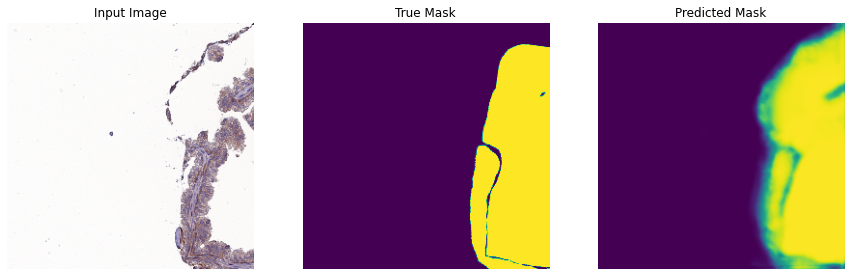


Sample Prediction after epoch 10

291/291 [==============================] - 199s 283ms/step - loss: 0.0794 - dice_coefficient: 0.8752 - val_loss: 0.1036 - val_dice_coefficient: 0.8203


In [ ]:
# First train with 10 epochs, for fine-tuning encoders of UNet. 
manager.fit_and_save(
                     train_ds, 
                     validation_data=val_ds, 
                     epochs=10, 
                     csv_id=CSV_ID,
                     save_best=False,
                     early_stopping=False,
                     reduce_lr=False
                     )

Image: (256, 256, 3)
Mask: (256, 256, 1)
Predict: (1, 256, 256, 1)


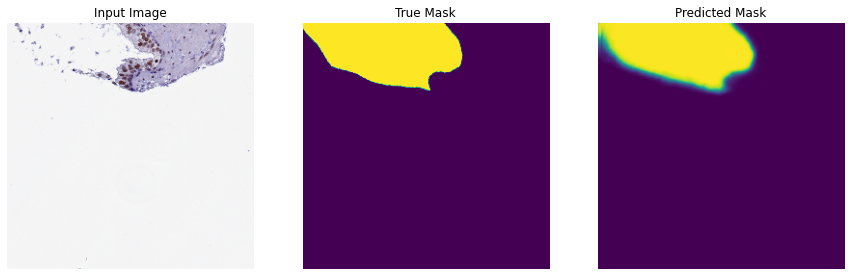


Sample Prediction after epoch 12

291/291 [==============================] - 233s 399ms/step - loss: 0.0394 - dice_coefficient: 0.9389 - val_loss: 0.1256 - val_dice_coefficient: 0.8194 - lr: 4.0000e-06
Epoch 12: early stopping
Train finished. Saving model...
Model saved as model_0


In [ ]:
# Now train with smaller learning rate
for layer in manager.model.layers:
    layer.trainable = True
manager.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005))
manager.fit_and_save(
                     train_ds, 
                     validation_data=val_ds, 
                     epochs=EPOCHS, 
                     csv_id=CSV_ID,
                     save_best=SAVE_BEST,
                     monitor_mode=MONITOR_MODE,
                     early_stopping=EARLY_STOPPING,
                     early_stopping_patience=EARLY_STOPPING_PATIENCE,
                     reduce_lr=REDUCE_LR,
                     reduce_lr_factor=REDUCE_LR_FACTOR,
                     reduce_lr_patience=REDUCE_LR_PATIENCE
                     )
print("Train finished. Saving model...")
manager.save(id=0)

In [ ]:
! zip -r saved_models.zip saved_models/model_0

  adding: saved_models/model_0/ (stored 0%)
  adding: saved_models/model_0/assets/ (stored 0%)
  adding: saved_models/model_0/saved_model.pb (deflated 91%)
  adding: saved_models/model_0/keras_metadata.pb (deflated 96%)
  adding: saved_models/model_0/variables/ (stored 0%)
  adding: saved_models/model_0/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_models/model_0/variables/variables.index (deflated 79%)


#### Show Plots

Plot saved as 2022-09-03_20-45.png


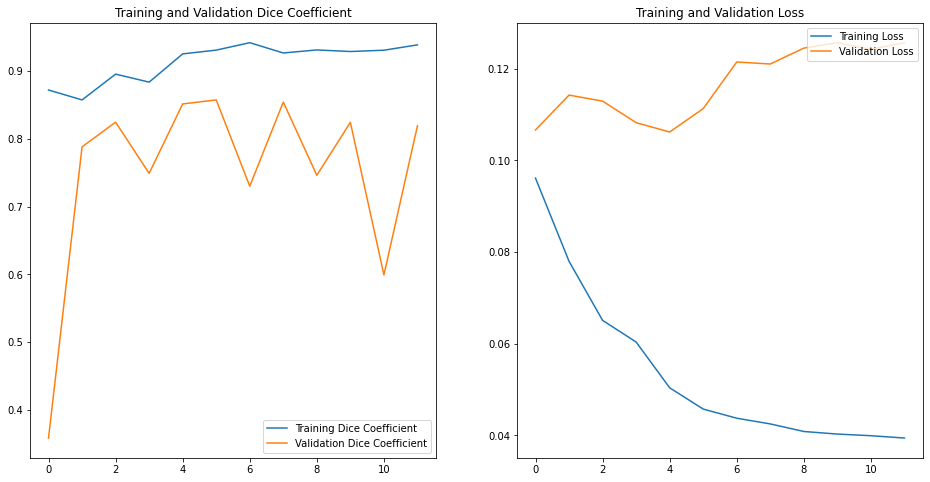

In [ ]:
manager.show_all_results()

In [ ]:
manager.evaluate(test_ds)

37/37 [==============================] - 16s 327ms/step - loss: 0.1692 - dice_coefficient: 0.9132
Test Dice Coefficient: 0.9131910800933838


In [ ]:
log_df = pd.read_csv('logs/logs_0.csv')
log_df.head(1)

,epoch,dice_coefficient,loss,val_dice_coefficient,val_loss
0,0,0.113686,0.676631,0.36606,0.829624


### Predict Test

In [ ]:
! unzip -q saved_models.zip

In [ ]:
manager = Manager(loads_model=True, base_path='/content', training_id=0)

Model loaded from model_0


In [ ]:
def rle_encode(img, threshold=0.5):
    img = img.T
    pixels = np.concatenate((np.array([0]), img.flatten(), np.array([0])))
    beginings = np.where( (pixels >= threshold) & (np.concatenate((np.array([2]), pixels[:-1])) < threshold) )[0]
    ends = np.where( (pixels >= threshold) & (np.concatenate((pixels[1:], np.array([2]))) < threshold) )[0]

    rle = ''
    for begin, end in zip(beginings, ends):
        rle += str(begin-1) + ' ' + str(end - begin + 1) + ' '
    return rle[:-1]

def get_correct_dimension(number, divisible):
    if number % divisible == 0:
        return number
    else:
        return number + divisible - (number % divisible)

def correct_image_size(img, size):
    if img.shape[0] != size:
        img = cv2.resize(img, (size, size))
    return img

def display_overlay(image, mask):
    plt.figure(figsize = (7,7))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)

In [ ]:
test_images_dir = 'dataset/test_images'
test_images = [name for name in os.listdir(test_images_dir)]
test_images = [i for i in test_images if '.tiff' in i]
test_images = sorted(test_images, key=lambda x: int(x.split('.')[0]))

In [ ]:
PATCH_SIZE = 1024
submission_df = None
submission_dict = {'id': [], 'rle': []}
for test_image_filename in tqdm(test_images):
    image_id = int(test_image_filename.split('.')[0])
    submission_dict['id'].append(image_id)
    test_image_file = test_images_dir + '/' + test_image_filename
    image = cv2.imread(test_image_file)
    ORIGINAL_SIZE = image.shape[0]
    image = correct_image_size(image, get_correct_dimension(image.shape[0], PATCH_SIZE))
    CORRECTED_SIZE = image.shape[0]

    image = tf.cast(image, tf.float32) / 255.0

    test_mask = np.zeros((CORRECTED_SIZE, CORRECTED_SIZE))

    for i in range(0, image.shape[0], PATCH_SIZE):
        for j in range(0, image.shape[1], PATCH_SIZE):
            smaller_image = image[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            smaller_image = cv2.resize(smaller_image.numpy(),  (HEIGHT, WIDTH))
            smaller_image = tf.expand_dims(smaller_image, 0) # Create a batch
            smaller_mask = manager.model.predict(smaller_image)

            smaller_mask = np.where(smaller_mask > THRESHOLD, 1, 0)
            
            # smaller_mask = tf.math.argmax(smaller_mask, axis=-1)
            smaller_mask = tf.cast(smaller_mask, tf.float32)

            # smaller_mask = tf.expand_dims(smaller_mask[0], 2)
            smaller_mask = cv2.resize(smaller_mask[0].numpy(), (PATCH_SIZE, PATCH_SIZE))

            test_mask[i:i+PATCH_SIZE, j:j+PATCH_SIZE] = smaller_mask

    test_mask = correct_image_size(test_mask, ORIGINAL_SIZE)
    # plt.imshow(test_mask)
    cv2.imwrite(str(image_id) +'_mask.png', test_mask * 255)

    rle = rle_encode(test_mask)
    submission_dict['rle'].append(rle)

submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv('submission.csv', index=False)

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


In [ ]:
submission_df

,id,rle
0,10044,1525731 30 1528731 31 1531730 32 1534729 34 15...
1,10078,40777 2 42799 4 44823 3 910818 4 912840 7 9148...
2,27879,1441268 30 1444266 34 1447266 35 1450265 37 14...
